============================================ ; Title: Customer Feedback Theme Detection (Amazon Electronics Reviews) ; Author: Derek Lamb ; Date: 14 October 2025 ; Modified By: Derek Lamb ; Description: Analyzes Amazon Electronics review data to identify recurring ; customer themes using text mining, clustering, and sentiment analysis. ; The project uses TF-IDF, topic modeling, and VADER sentiment scoring ; to uncover the most discussed topics and associated sentiment. ;=========================================== ; Course: DSC680 – Applied Data Science ; Project: Project 2 ; Attributions: ; - Dataset: Amazon Product Review Dataset (Electronics 5-core) ; https://nijianmo.github.io/amazon/index.html (accessed 14 Oct 2025) ; - Preprocessing and TF-IDF pipeline adapted from scikit-learn documentation: ; https://scikit-learn.org/stable/modules/feature_extraction.html (accessed 14 Oct 2025) ; - VADER sentiment analysis adapted from NLTK documentation: ; https://www.nltk.org/howto/sentiment.html (accessed 14 Oct 2025) ;===========================================


In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
print("Thread caps set.")


Thread caps set.


In [3]:
import os, re, gzip, json, string, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
for res in ['stopwords', 'wordnet', 'omw-1.4', 'vader_lexicon']:
    try:
        nltk.data.find(f'corpora/{res}')
    except LookupError:
        nltk.download(res)

from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

plt.rcParams["figure.figsize"] = (9,5)
plt.rcParams["axes.grid"] = True

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dereklamb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/dereklamb/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dereklamb/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
# Point to your file (plain JSONL)
DATA_PATH = os.path.expanduser("~/Downloads/Video_Games_5.json")
assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}"

TARGET_SAMPLE = 150_000   # adjust: 50k (very safe) to 200k (needs more RAM)
KEEP_COLS = ['reviewText','summary','overall','unixReviewTime','asin']

def is_gzip(path):
    with open(path, "rb") as fh:
        return fh.read(2) == b"\x1f\x8b"

def stream_sample_jsonl(path, k=100_000, keep_cols=None, seed=42):
    keep_cols = keep_cols or KEEP_COLS
    rng = random.Random(seed)
    sample = []
    n = 0
    gz = is_gzip(path)
    opener = (lambda p: gzip.open(p, "rt", encoding="utf-8", errors="ignore")) if gz \
             else (lambda p: open(p, "rt", encoding="utf-8", errors="ignore"))
    with opener(path) as fh:
        for line in fh:
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
            except Exception:
                continue
            row = {c: obj.get(c, None) for c in keep_cols}
            n += 1
            if len(sample) < k:
                sample.append(row)
            else:
                # reservoir sampling
                j = rng.randint(0, n-1)
                if j < k:
                    sample[j] = row
    df = pd.DataFrame(sample)
    return df, n

df, total_seen = stream_sample_jsonl(DATA_PATH, k=TARGET_SAMPLE, keep_cols=KEEP_COLS, seed=RANDOM_SEED)
print(f"Sampled {len(df):,} of ~{total_seen:,} reviews")
df.head()


Sampled 150,000 of ~497,577 reviews


,reviewText,summary,overall,unixReviewTime,asin
0,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,5.0,1445040000,0700026657
1,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",4.0,1437955200,0700026657
2,IT IS A GOOD GAME,Five Stars,5.0,1455926400,B0019R4VEO
3,"It worked flawlessly out of the box. It's red,...",Five Stars,5.0,1416182400,B0094X227I
4,"great game, I love it and have played it since...",love this game,5.0,1419465600,0700026657


In [5]:
STOP = set(stopwords.words('english'))
LEM  = WordNetLemmatizer()

def basic_clean(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r"http\\S+|www\\S+", " ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\\s+", " ", text).strip()
    return text

def norm_text(text):
    toks = [w for w in text.split() if w not in STOP and len(w) > 2]
    lem = [LEM.lemmatize(w) for w in toks]
    return " ".join(lem)

def preprocess(df, text_cols=('summary','reviewText')):
    out = df.copy()
    out['text'] = out[list(text_cols)].fillna('').agg(' '.join, axis=1)
    out['text_clean'] = out['text'].apply(basic_clean)
    out['text_norm']  = out['text_clean'].apply(norm_text)
    out = out[out['text_norm'].str.strip().astype(bool)]
    return out

df = preprocess(df)
print("After cleaning:", df.shape)


After cleaning: (149934, 8)


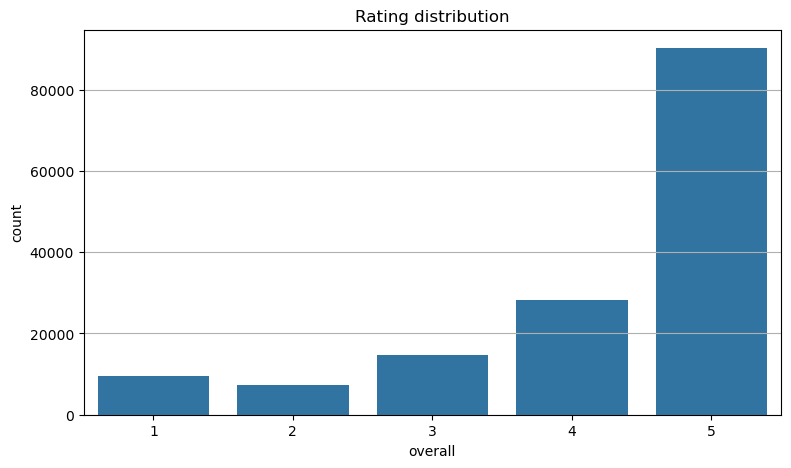

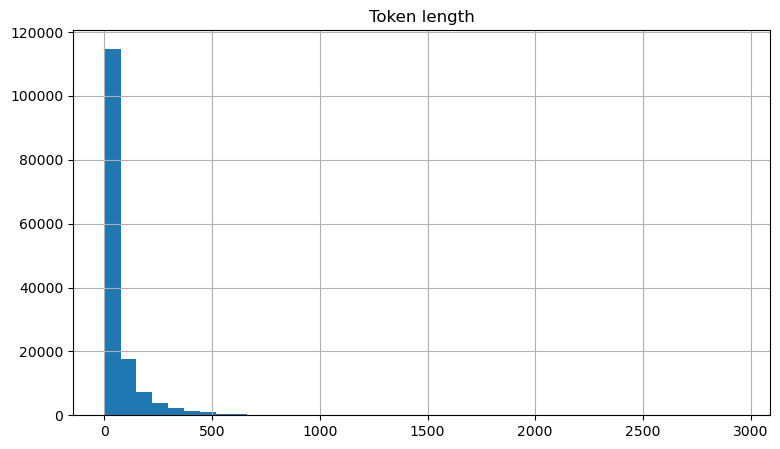

In [6]:
if 'overall' in df.columns and df['overall'].notna().any():
    sns.countplot(x=df['overall'].dropna().astype(int))
    plt.title("Rating distribution"); plt.show()

df['len_tokens'] = df['text_norm'].str.split().apply(len)
df['len_tokens'].hist(bins=40); plt.title("Token length"); plt.show()


In [7]:
# HashingVectorizer uses constant RAM (no global vocab), great for large samples
hv = HashingVectorizer(
    n_features=2**20,          # 1,048,576 features; reduce to 2**18 if RAM is tight
    alternate_sign=False,      # keep positive counts for SVD stability
    stop_words='english',
    ngram_range=(1,2),
    norm=None                  # we’ll normalize after SVD
)

X_hash = hv.transform(df['text_norm'])   # lazy transform; low memory peak
print("Hashing matrix shape:", X_hash.shape)

# Dimensionality reduction to ~200 components
svd = TruncatedSVD(n_components=200, random_state=RANDOM_SEED)
X_red = svd.fit_transform(X_hash)
X_red = normalize(X_red)
print("Reduced shape:", X_red.shape, "| Explained variance:", svd.explained_variance_ratio_.sum())


Hashing matrix shape: (149934, 1048576)
Reduced shape: (149934, 200) | Explained variance: 0.41023418151766355


In [8]:
# === macOS OpenBLAS fix: disable threadpoolctl inside scikit-learn ===
from contextlib import contextmanager
import sklearn.utils.fixes as skl_fixes

@contextmanager
def _noop_threadpool_limits(*args, **kwargs):
    # no-op context manager to bypass threadpoolctl calls
    yield

# Monkey-patch scikit-learn's internal reference
skl_fixes.threadpool_limits = _noop_threadpool_limits
print("Patched sklearn.utils.fixes.threadpool_limits → no-op")


Patched sklearn.utils.fixes.threadpool_limits → no-op


In [9]:
# === Strong patch: disable threadpoolctl calls inside sklearn ===
from contextlib import contextmanager

@contextmanager
def _noop_threadpool_limits(*args, **kwargs):
    # no-op context manager to bypass threadpoolctl calls
    yield

# 1) Patch the module where KMeans/MiniBatchKMeans actually calls it
import sklearn.cluster._kmeans as _sk_kmeans
_sk_kmeans.threadpool_limits = _noop_threadpool_limits

# 2) Also patch the public fixes module (for completeness)
import sklearn.utils.fixes as _sk_fixes
_sk_fixes.threadpool_limits = _noop_threadpool_limits

print("Patched: sklearn.cluster._kmeans.threadpool_limits and sklearn.utils.fixes.threadpool_limits → no-op")


Patched: sklearn.cluster._kmeans.threadpool_limits and sklearn.utils.fixes.threadpool_limits → no-op


In [10]:
n_samples = X_red.shape[0]

def pick_k(n):
    # heuristic; yields 8–12 for big samples, caps for small ones
    base = 8 if n < 20_000 else (10 if n < 100_000 else 12)
    return max(2, min(base, n - 1, n // 200 or 2))  # ~1 cluster per 200 docs, min 2

K = pick_k(n_samples)
print(f"Clustering with K={K} on {n_samples} samples")

mbkm = MiniBatchKMeans(n_clusters=K, random_state=RANDOM_SEED, batch_size=4096, n_init=5)
labels = mbkm.fit_predict(X_red)
df['topic'] = labels

sil = None
if n_samples >= 200 and K > 1:
    try:
        sil = silhouette_score(X_red, labels, metric='cosine')
    except Exception:
        pass
print("Silhouette:", sil)
print("Topic counts:", pd.Series(labels).value_counts().sort_index().to_dict())


Clustering with K=12 on 149934 samples
Silhouette: 0.1086604144464513
Topic counts: {0: 22115, 1: 18709, 2: 7466, 3: 30511, 4: 10989, 5: 5992, 6: 3596, 7: 16040, 8: 5552, 9: 11681, 10: 9422, 11: 7861}


In [11]:
# --- Add Sentiment Scores (VADER) ---
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Make sure VADER is available
nltk.download('vader_lexicon', quiet=True)
sia = SentimentIntensityAnalyzer()

# Apply sentiment to each review's normalized text
df['compound'] = df['text_norm'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])
df['sentiment_label'] = pd.cut(df['compound'],
                               bins=[-1, -0.05, 0.05, 1],
                               labels=['Negative', 'Neutral', 'Positive'])

print(df[['text_norm', 'compound', 'sentiment_label']].head())


                                           text_norm  compound sentiment_label
0                 great game bit hard get hang great    0.8316        Positive
1  spite fun liked played alright steam bit troub...    0.8680        Positive
2                                five star good game    0.4404        Positive
3  five star worked flawlessly box red cover red ...    0.4404        Positive
4     love game great game love played since arrived    0.9423        Positive


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np, re

# generic praise/noisy phrases to avoid in titles
BAN_PHRASES = {
    "great game","good game","fun game","best game","love game","works great",
    "excellent product","star great","star love","star good","xbox 360"
}
BAN_WORDS = {"great","good","fun","best","love","amazing","awesome","excellent","product","game","works","star"}

def _title_case(s: str) -> str:
    small = {"and","or","the","of","in","on","for","to","a","an","with"}
    words = s.split()
    return " ".join(w.capitalize() if i==0 or w not in small else w for i,w in enumerate(words))

def _pretty(s: str) -> str:
    s = re.sub(r"\s*&\s*", " & ", s)
    s = s.replace(" and ", " & ")
    s = re.sub(r"\s+", " ", s).strip()
    return _title_case(s)

def generate_topic_titles(df, topic_col='topic', text_col='text_norm',
                          ngram_range=(1,2), min_df=5, max_df=0.8, top_k=8):
    """
    Fit TF-IDF per topic on unigrams+bigrams, then pick a meaningful phrase:
    - not in BAN_PHRASES
    - contains at least one content word not in BAN_WORDS
    Fallback to unigrams if needed.
    """
    titles = {}
    for t, g in df.groupby(topic_col):
        texts = g[text_col].astype(str).tolist()
        if not texts:
            titles[t] = f"Topic {t}"
            continue

        vect = TfidfVectorizer(ngram_range=ngram_range, min_df=min_df,
                               max_df=max_df, stop_words='english', sublinear_tf=True)
        try:
            X = vect.fit_transform(texts)
            terms = np.array(vect.get_feature_names_out())
            if terms.size == 0:
                raise ValueError("empty vocab")
            scores = np.asarray(X.sum(axis=0)).ravel()
            order = scores.argsort()[::-1][:max(top_k, 1)]
            cands = [terms[i] for i in order]

            # filter out generic praise / low-info phrases
            def ok(p):
                p_l = p.lower()
                if p_l in BAN_PHRASES: return False
                tokens = p_l.split()
                # keep if any token is not a banned generic word
                return any(tok not in BAN_WORDS for tok in tokens)

            cands = [c for c in cands if ok(c)]
            if not cands:
                raise ValueError("no good candidates")

            titles[t] = _pretty(cands[0])
            continue
        except Exception:
            # fallback: top informative unigrams
            vect2 = TfidfVectorizer(ngram_range=(1,1), min_df=1, max_df=1.0,
                                    stop_words='english', sublinear_tf=True)
            X2 = vect2.fit_transform(texts)
            terms2 = np.array(vect2.get_feature_names_out())
            if terms2.size == 0:
                titles[t] = f"Topic {t}"
            else:
                scores2 = np.asarray(X2.sum(axis=0)).ravel()
                order2 = scores2.argsort()[::-1][:3]
                label = " ".join(terms2[i] for i in order2)
                titles[t] = _pretty(label)
    return titles



In [13]:
# Add lemmatization and custom stopwords
import spacy
nlp = spacy.load("en_core_web_sm")

CUSTOM_STOPWORDS = {"game","games","product","amazon","review"}
def clean_text(text):
    doc = nlp(text.lower())
    tokens = [
        t.lemma_ for t in doc
        if not t.is_stop and not t.is_punct and t.lemma_ not in CUSTOM_STOPWORDS
    ]
    return " ".join(tokens)

df["text_norm"] = df["text"].astype(str).apply(clean_text)


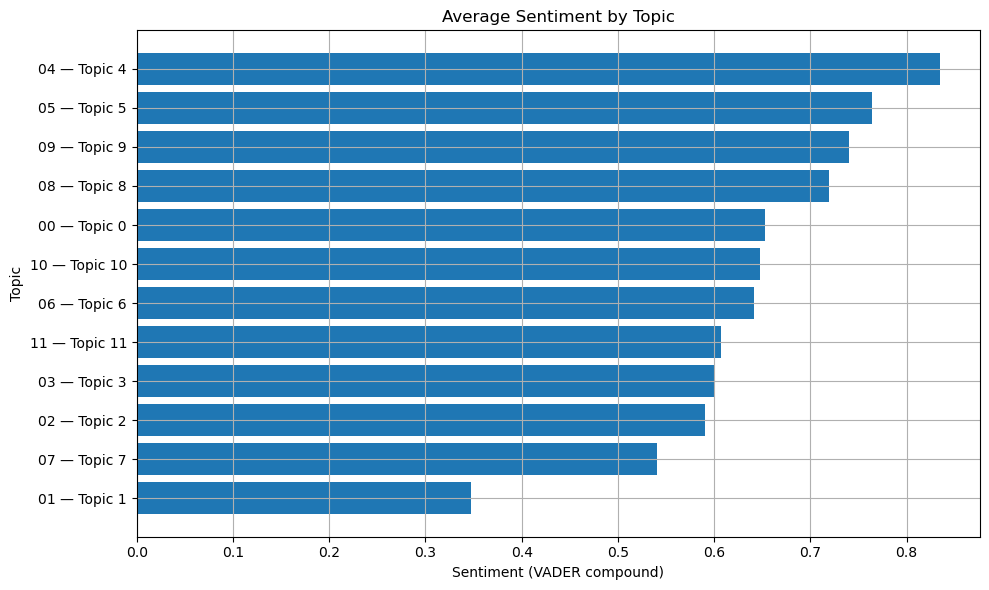

In [15]:
# --- Fix missing columns and plot Avg Sentiment by Topic ---

import pandas as pd
import matplotlib.pyplot as plt

# 1) Ensure sentiment column
if 'compound' not in df.columns:
    from nltk.sentiment import SentimentIntensityAnalyzer
    import nltk
    nltk.download('vader_lexicon', quiet=True)
    sia = SentimentIntensityAnalyzer()
    text_col = 'text_norm' if 'text_norm' in df.columns else ('text' if 'text' in df.columns else None)
    assert text_col is not None, "Expected 'text_norm' or 'text' in dataframe."
    df['compound'] = df[text_col].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

# 2) Ensure human-readable topic labels
if 'topic_label' not in df.columns:
    if 'topic_titles' in globals() and isinstance(topic_titles, dict) and len(topic_titles):
        df['topic_label'] = df['topic'].map(topic_titles).fillna(df['topic'].astype(str).radd('Topic '))
    else:
        df['topic_label'] = df['topic'].astype(str).radd('Topic ')

# Optional: combine id + label for uniqueness/clarity
df['topic_name'] = df['topic'].astype(str).str.zfill(2) + " — " + df['topic_label']

# 3) Compute means and plot
topic_means = df.groupby('topic_name')['compound'].mean().sort_values()

plt.figure(figsize=(10,6))
plt.barh(topic_means.index, topic_means.values)
plt.title("Average Sentiment by Topic")
plt.xlabel("Sentiment (VADER compound)")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()



In [24]:
# --- Recreate topic_titles dictionary if missing ---

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re

def title_case_phrase(s: str) -> str:
    """Helper: nice capitalization."""
    if not s: return s
    small = {"and","or","the","of","in","on","for","to","a","an","with"}
    words = s.split()
    tc = [w.capitalize() if i==0 or w not in small else w for i,w in enumerate(words)]
    return " ".join(tc)

def prettify_label(s: str) -> str:
    s = re.sub(r"\s*&\s*", " & ", s)
    s = s.replace(" and ", " & ")
    s = s.replace(" - ", " ")
    s = re.sub(r"\s+", " ", s).strip()
    return title_case_phrase(s)

def generate_topic_titles(df, topic_col='topic', text_col='text_norm',
                          ngram_range=(2,3), min_df=2, max_df=0.9, top_k=5):
    """Generate readable topic labels from TF-IDF bigrams/trigrams."""
    topic_titles = {}
    for t, g in df.groupby(topic_col):
        texts = g[text_col].astype(str).tolist()
        vect = TfidfVectorizer(ngram_range=ngram_range,
                               min_df=min_df, max_df=max_df,
                               stop_words='english', sublinear_tf=True)
        try:
            X = vect.fit_transform(texts)
            scores = np.asarray(X.sum(axis=0)).ravel()
            terms = np.array(vect.get_feature_names_out())
            order = scores.argsort()[::-1][:top_k]
            candidates = [terms[i] for i in order if len(terms[i].split()) >= 2]
            label = prettify_label(candidates[0]) if candidates else f"Topic {t}"
            topic_titles[t] = label
        except Exception:
            topic_titles[t] = f"Topic {t}"
    return topic_titles

# Generate titles
topic_titles = generate_topic_titles(df)

# Attach to dataframe
df['topic_label'] = df['topic'].map(topic_titles).fillna(df['topic'].astype(str).radd('Topic '))

print("✅ topic_titles recreated with", len(topic_titles), "entries.")
df[['topic', 'topic_label']].drop_duplicates().head()


# Use the existing dictionary from topic labeling step
df['topic_label'] = df['topic'].map(topic_titles).fillna(df['topic'].astype(str).radd('Topic '))


✅ topic_titles recreated with 12 entries.


In [25]:
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['text'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

sent_table = df.groupby('topic')['sentiment'].agg(['count','mean','median']).sort_values('mean')
sent_table.head(20)


,count,mean,median
topic,,,
1,18709,0.358925,0.44660
7,16040,0.503477,0.78955
11,7861,0.556661,0.79640
2,7466,0.557355,0.49270
3,30511,0.565768,0.88460
10,9422,0.597001,0.89680
0,22115,0.604080,0.93610
6,3596,0.620536,0.81260
8,5552,0.666809,0.92010


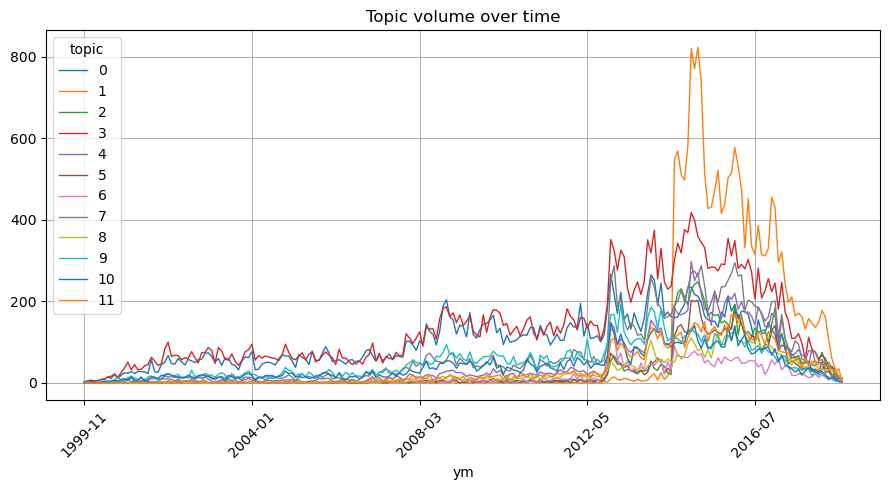

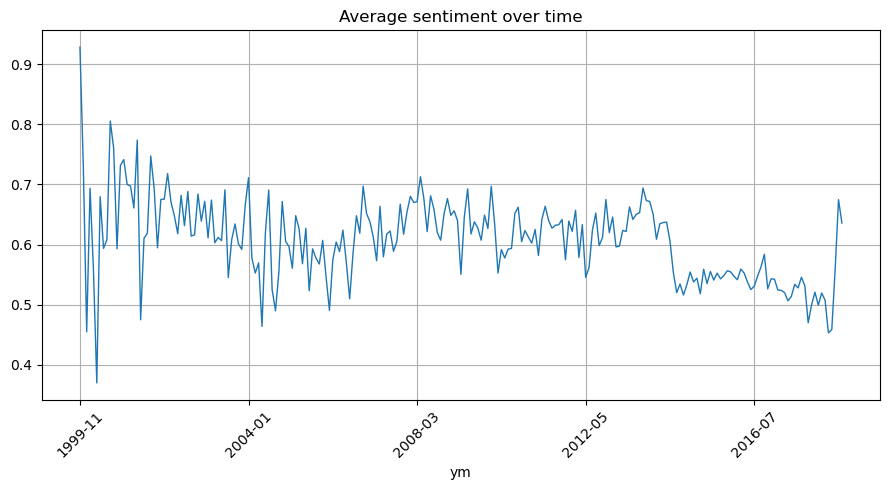

In [26]:
if 'unixReviewTime' in df.columns and df['unixReviewTime'].notna().any():
    df['date'] = pd.to_datetime(df['unixReviewTime'], unit='s', errors='coerce')
    if df['date'].notna().any():
        df['ym'] = df['date'].dt.to_period('M').astype(str)
        vol = df.pivot_table(index='ym', columns='topic', values='text', aggfunc='count').fillna(0)
        if vol.shape[0] > 1:
            vol.plot(kind='line', lw=1, title='Topic volume over time'); plt.xticks(rotation=45); plt.tight_layout(); plt.show()
        sent_t = df.groupby('ym')['sentiment'].mean()
        if sent_t.shape[0] > 1:
            sent_t.plot(kind='line', lw=1, title='Average sentiment over time'); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


In [27]:
def show_examples(frame, topic_id, n=3):
    ex = frame.loc[frame['topic']==topic_id, 'text'].head(n).tolist()
    print(f"\nTopic {topic_id} examples:")
    for e in ex:
        print("-", e[:400])

for t in sorted(df['topic'].unique())[:min(10, df['topic'].nunique())]:
    show_examples(df, t, n=3)



Topic 0 examples:
- But in spite of that it was fun, I liked it I played it a while but it was alright. The steam was a bit of trouble. The more they move these game to steam the more of a hard time I have activating and playing a game. But in spite of that it was fun, I liked it. Now I am looking forward to anno 2205 I really want to play my way to the moon.
- good comany I am very happy with my purchase of Sim Coaster.  My 12 year old son has had hours of fun playing this game.
It keeps him so entertained that I am able to enjoy reading my book without any interruptions.
S, George
- Yeah Right Most Wanted Need for Speed is a fun game that can get repetitive; that is, you're constantly crashing into things. However, I guess that's what makes it fun? I will point out that the racing wheel is a real bonus, as the player gets vibration feedback when they veer off course, or crash, naturally. I also want to point out that it's somewhat difficult to maintain a steady trajectory in 

Topic

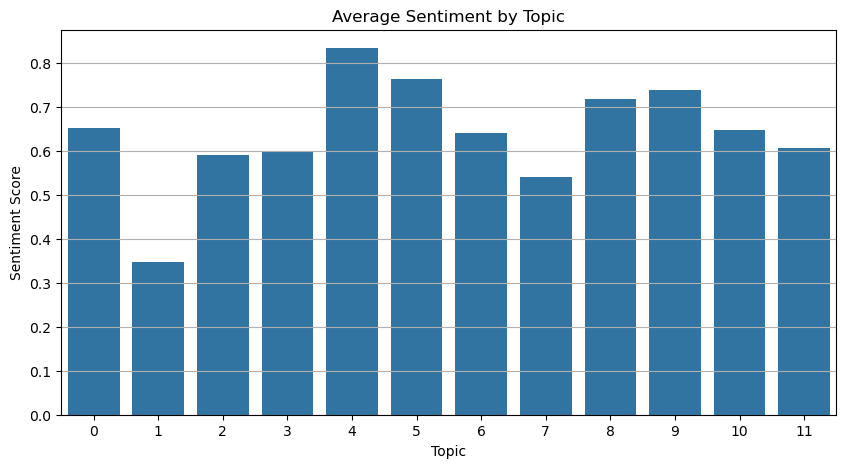

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

topic_means = df.groupby('topic')['compound'].mean().sort_values()
plt.figure(figsize=(10,5))
sns.barplot(x=topic_means.index, y=topic_means.values)
plt.title("Average Sentiment by Topic")
plt.xlabel("Topic")
plt.ylabel("Sentiment Score")
plt.show()
